In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq
import dict_minimize
from pytictoc import TicToc

import bvbq

# import bvbq.gp
# import bvbq.bvi
# import bvbq.distributions

W0807 19:48:41.499760 140548081370944 xla_bridge.py:137] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [310]:
random.random()

0.2618895672197128

In [3]:
key1 = jax.random.PRNGKey(250)
key2,_ = jax.random.split(key1)
mixmeans_test = 4*jax.random.normal(key1,shape=(12,1))
# mixmeans_test = jnp.ones((12,1))
mixmeans_test = jnp.array([[  1.8033],
                           [ -1.4296],
                           [ -1.9691],
                           [  1.2147],
                           [ -6.9166],
                           [-11.5672],
                           [ -1.5860],
                           [ -4.3302],
                           [  8.7410],
                           [ -1.3793],
                           [ -4.8774],
                           [  2.3949]])
mixvars_test = jnp.ones((12,1))
mixweights_test = jnp.ones(12)/12
# mixmeans_test = jnp.array([[3.0],[-3.0]])
# mixvars_test = jnp.ones((2,1))
# mixweights_test = jnp.ones(2)/2
# bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights)

In [56]:
def logprob_mixgaussians(x):
    return bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

xdata = jnp.linspace(-20,20,51).reshape(-1,1)
# ydata = logprob_t(xdata,2.5)
ydata = logprob_mixgaussians(xdata)
logprobgp = bvbq.gp.SimpleGP(1,kind='sqe',noise=0,zeromax=True)
logprobgp.mean = -10.0
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xdata,ydata,empirical_params=False)
logprobgp.optimize_params()

OrderedDict([('raw_theta', DeviceArray(0.5413248, dtype=float32)),
             ('raw_lengthscale', DeviceArray(0.5413248, dtype=float32)),
             ('raw_noise', DeviceArray(-inf, dtype=float32))])

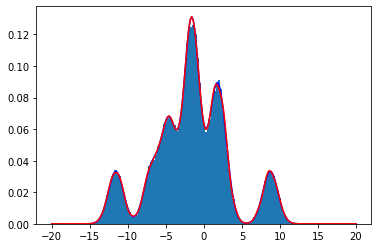

In [57]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
# yplot1 = logprob_t(xplot,2.5)
yplot2 = logprobgp.predict(xplot,return_cov=False)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
plt.hist(samples1.flatten(),density=True,bins=100);

In [58]:
def mcbq_dmvn_elbo(logprobgp,mean,var,nsamples):
    term1 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var))
    term2 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False)
    return term1 + term2
#     term1 = distrib.monte_carlo_entropy(nsamples)
#     term2 = bq.monte_carlo_bayesian_quadrature(logprobgp,distrib,nsamples)
#     return term1 + term2

def objective_function_elbo(params):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    res = -mcbq_dmvn_elbo(logprobgp,mean,var,1000)
    return res

In [59]:
params = {'mean':jnp.zeros(1)-1.0,'rawvar':jnp.zeros(1)}
jax.value_and_grad(objective_function_elbo)(params)
maxiter = 100
alpha = 1e-1
optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha)
func_and_grad_elbo = jax.value_and_grad(objective_function_elbo)
optwrapper.init(params,func_and_grad_elbo)
for k in range(maxiter):
    value,grads = optwrapper.step()
    params = optwrapper.params
#     print(value,params['mean'],jax.nn.softplus(params['rawvar']))
mean,rawvar = params['mean'],params['rawvar']
var = jax.nn.softplus(rawvar)
distrib = bvbq.distributions.DiagonalNormalDistribution(mean,var)

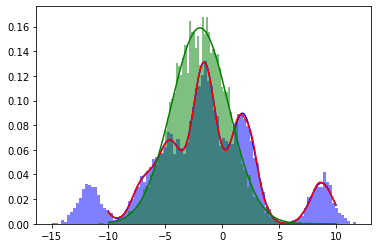

In [60]:
xplot = np.linspace(-10,10,201).reshape(-1,1)
# yplot1 = logprob_t(xplot,2.5)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = distrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')
samples1 = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(10000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test,
                                                             key1,key2)
samples3 = distrib.sample(10000)
plt.hist(samples1.flatten(),density=True,bins=100,alpha=0.5,color='blue');
plt.hist(samples3.flatten(),density=True,bins=100,alpha=0.5,color='green');

In [61]:
# bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                         x,mixmeans_test,mixvars_test,mixweights_test)


In [62]:
data = np.load('/home/danilo/Temp/TestBVBQ/data.npz')
data2 = np.load('/home/danilo/Temp/TestBVBQ/data2.npz')

In [288]:
logprobgp = bvbq.gp.SimpleGP(1,kind='smatern32',noise=0,zeromax=True)
logprobgp.mean = -20.0
logprobgp.noise = data['noise']
logprobgp.lengthscale = data['lengthscale']
logprobgp.theta = data['outputscale']
logprobgp.set_data(data['X'],data['y'].flatten(),empirical_params=False)
# logprobgp.optimize_params()

In [289]:
def mcbq_dmvn_relbo_test(logprobgp,mean,var,mixmeans,mixvars,mixweights,
                         zsamples,logdelta=-20,reg=1e-2):
#     subkey,key = jax.random.split(key)
#     samples = bvbq.distributions.DiagonalNormalDistribution.sample_(nsamples,mean,var,subkey)
    tictoc = TicToc()
    samples = jnp.sqrt(var)*zsamples+mean
    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) #Variance
#     print(mixmeans,mixvars,mixweights)
#     term2 = bvbq.utils.lb_mvn_mixmvn_cross_entropy(mean,var,mixmeans,mixvars,mixweights,logdelta)
    term2 = -bvbq.utils.logbound(
                bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples,mixmeans,mixvars,mixweights),
                logdelta).mean()
#     term2 = -bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
#                     samples,mixmeans,mixvars,mixweights).mean()
    term3 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var)) #Entropy
    return term1,term2,term3
tictoc.tic()
mcbq_dmvn_relbo_test(logprobgp,data['mean'],data['var'],data['mixmeans'],data['mixvars'],data['mixweights'],data['zsamples'],logdelta=-20,reg=1e-2)
tictoc.toc()

Elapsed time is 0.212931 seconds.


In [314]:
def mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,
                    logdelta=-10,reg=1e-2):
    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) #Variance
    term2 = bvbq.utils.lb_mvn_mixmvn_cross_entropy(mean,var,mixmeans,mixvars,mixweights,logdelta)
    term3 = 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*var)) #Entropy
    return term1 + term2 + reg*term3

def mcbq_mixdmvn_gradboost_delbodw(weight,logprobgp,mean,var,
                                   mixmeans,mixvars,mixweights,
                                   key,nsamples=100):
    mixmeans_up = jnp.vstack([mixmeans,mean])
    mixvars_up = jnp.vstack([mixvars,var])
    mixweights_up = jnp.append((1-weight)*mixweights,weight)

    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)

    nmixtures,ndim = mixmeans.shape
    catinds = jax.random.choice(subkeya,nmixtures,shape=(nsamples,),p=mixweights)
    zprevious = jax.random.normal(subkeyb,shape=(nsamples,ndim))
    zproposal = jax.random.normal(subkeyc,shape=(nsamples,ndim))
    samplesprevious = bvbq.utils.mixdmvn_samples_from_zsamples_catinds(mixmeans,mixvars,zprevious,catinds)
    samplesproposal = bvbq.utils.dmvn_samples_from_zsamples(mean,var,zproposal)

    term1 = bvbq.bq.separable_dmvn_bq(logprobgp,mean,var,return_var=False) 
    term2 = -bvbq.bq.separable_mixdmvn_bq(logprobgp,mixmeans,
                                          mixvars,mixweights,
                                          return_var=False)
    term3 = -bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                samplesproposal,mixmeans_up,mixvars_up,mixweights_up).mean()
    term4 = bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                samplesprevious,mixmeans_up,mixvars_up,mixweights_up).mean()
    return term1 + term2 + term3 + term4

def join_distributions(samples,weight,mean,var,mixmeans,mixvars,mixweights):
    terma = bvbq.distributions.MixtureDiagonalNormalDistribution.logprob_(
                    samples,mixmeans,mixvars,mixweights)
    termb = bvbq.distributions.DiagonalNormalDistribution.logprob_(
                    samples,mean,var)
    term = bvbq.utils.logsumexp(jnp.stack([terma,termb],axis=-1),
                                weights=jnp.array([1.-weight,weight]),
                                axis=-1)
    return term

In [315]:
def objective_function_relbo(params,mixmeans,mixvars,mixweights,logdelta,reg):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    res = -mcbq_dmvn_relbo(logprobgp,mean,var,mixmeans,mixvars,mixweights,logdelta,reg)
    return res

func_and_grad_relbo = jax.value_and_grad(objective_function_relbo,argnums=0)

In [316]:
func_and_grad_relbo(params,mixmeans,mixvars,mixweights,-20,-1.0)

(DeviceArray(4.3471627, dtype=float32),
 OrderedDict([('mean', DeviceArray([0.516326], dtype=float32)),
              ('rawvar', DeviceArray([0.5060179], dtype=float32))]))

In [317]:
subkey,key = jax.random.split(key)
func_and_grad_gradboost(weight,mean,var,mixmeans,mixvars,mixweights,subkey)

(DeviceArray(0.7377595, dtype=float32), DeviceArray(-1.0448856, dtype=float32))

In [318]:
mcbq_mixdmvn_gradboost_delbodw(weight,logprobgp,mean,var,mixmeans,mixvars,mixweights,subkey,nsamples=100)

DeviceArray(0.92413974, dtype=float32)

In [320]:
# mean,var = distrib.params
# mixmeans = mean.reshape(1,-1)
# mixvars = var.reshape(1,-1)
dim = 1
mean = jnp.zeros((dim,))
var = (20.0/3)**2*jnp.ones((dim,))
mean,var = distrib.params
mixmeans = jnp.expand_dims(mean,-1)
mixvars = jnp.expand_dims(var,-1)*12
mixweights = jnp.ones(1)

# alpha_relbo = 1e-3
# maxiter_relbo = 300
alpha_boost = 1e-2
maxiter_boost = 100
maxiter = 400
# optwrapper = bvbq.optwrapper.JaxOptWrapper("adam",alpha_relbo)

key = jax.random.PRNGKey(365)

tictoc = TicToc()
for k in range(maxiter):
    tictoc.tic()
    subkeya,key = jax.random.split(key)
    subkeyb,key = jax.random.split(key)
    subkeyc,key = jax.random.split(key)
    mean_init = bvbq.distributions.MixtureDiagonalNormalDistribution.sample_(
                    1,mixmeans,mixvars,mixweights,subkeya,subkeyb)[0]
    var_init = jnp.array(scipy.stats.halfnorm.rvs(size=(1,)),dtype=jnp.float32)
    rawvar_init = jnp.log(jnp.exp(var_init)-1)
    params = {'mean':mean_init,
              'rawvar':rawvar_init}
    optwrapper.init(params,func_and_grad_relbo)
    tictoc.tic()
    params = collections.OrderedDict(params)
    res = dict_minimize.jax_api.minimize(func_and_grad_relbo, params,
                                         args=(mixmeans,mixvars,mixweights,-20,random.random()),
                                         method='L-BFGS-B',
                                         tol=1e-6)
    mean,var = params['mean'],jax.nn.softplus(params['rawvar'])
    weight = 1e-4
    tictoc.tic()
    for i in range(maxiter_boost):
        gradweight = -mcbq_mixdmvn_gradboost_delbodw(weight,logprobgp,mean,var,
                                                    mixmeans,mixvars,mixweights,
                                                    key,nsamples=100)
        dweight = alpha_boost/(k+1)*gradweight
        weight -= dweight
        weight = jnp.clip(weight,1e-4,1-1e-4)
        if abs(gradweight) < 1e-4:
            break
    tictoc.toc()
#     mixdistrib.add_component(mean,var,weight)
    mixweights = jnp.append((1-weight)*mixweights,weight)
    mixmeans = jnp.vstack([mixmeans,mean])
    mixvars = jnp.vstack([mixvars,var])
    print(k,mean,var,weight)
    print('--')
    

Elapsed time is 1.101111 seconds.
0 [-16.664904] [0.62444484] 1e-04
--
Elapsed time is 1.126984 seconds.
1 [0.42489395] [0.8196269] 0.8061139
--
Elapsed time is 1.463558 seconds.
2 [0.5247457] [0.56346494] 1e-04
--
Elapsed time is 1.204797 seconds.
3 [-0.0261467] [1.1323335] 0.12993187
--
Elapsed time is 1.371245 seconds.
4 [1.0976951] [0.3314431] 1e-04
--
Elapsed time is 1.311772 seconds.
5 [0.3637458] [0.1521103] 1e-04
--
Elapsed time is 1.106821 seconds.
6 [-0.58427745] [1.0158355] 0.116808295
--
Elapsed time is 1.196678 seconds.
7 [-0.41048166] [0.49766386] 1e-04
--
Elapsed time is 1.216856 seconds.
8 [7.782946] [0.7279423] 0.057546936
--
Elapsed time is 1.154162 seconds.
9 [-0.6723615] [0.19369864] 0.036843445
--
Elapsed time is 1.154778 seconds.
10 [2.921185] [0.4463965] 0.09658364
--
Elapsed time is 1.261560 seconds.
11 [2.4528837] [0.7394229] 0.05897041
--
Elapsed time is 1.407664 seconds.
12 [-0.36763215] [0.41561583] 1e-04
--
Elapsed time is 1.309378 seconds.
13 [0.7133202] [

Elapsed time is 2.097197 seconds.
111 [1.8759956] [0.7572026] 0.00016232698
--
Elapsed time is 2.110013 seconds.
112 [0.21656162] [2.6497548] 1e-04
--
Elapsed time is 1.790687 seconds.
113 [-1.3580787] [0.6855404] 0.0034583283
--
Elapsed time is 1.958978 seconds.
114 [4.038979] [0.22670718] 1e-04
--
Elapsed time is 2.095105 seconds.
115 [-0.94000447] [0.25368315] 0.002634448
--
Elapsed time is 1.867308 seconds.
116 [8.064912] [0.05356941] 1e-04
--
Elapsed time is 1.863235 seconds.
117 [3.0189044] [0.12022992] 0.0011571227
--
Elapsed time is 1.981696 seconds.
118 [0.15091187] [0.6489733] 1e-04
--
Elapsed time is 2.018895 seconds.
119 [-0.6603459] [0.7566426] 1e-04
--
Elapsed time is 2.178379 seconds.
120 [-7.0987062] [0.75789726] 0.0093341265
--
Elapsed time is 2.101553 seconds.
121 [-0.67930514] [1.5050337] 0.0010576181
--
Elapsed time is 2.134077 seconds.
122 [-3.7801256] [0.1034848] 0.0049366653
--
Elapsed time is 2.150698 seconds.
123 [-2.7022994] [0.06982139] 0.0032283843
--
Elapse

KeyboardInterrupt: 

In [321]:
res

OrderedDict([('mean', DeviceArray([-4.688917], dtype=float32)),
             ('rawvar', DeviceArray([-2.817571], dtype=float32))])

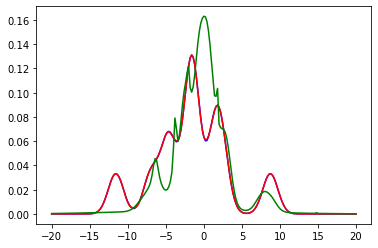

In [322]:
boostdistrib = bvbq.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot)
yplot2 = logprobgp.predict(xplot,return_cov=False)
yplot3 = boostdistrib.logprob(xplot).reshape(-1,1)
plt.plot(xplot,jnp.exp(yplot1),'b')
plt.plot(xplot,jnp.exp(yplot2),'r')
plt.plot(xplot,jnp.exp(yplot3),'g')

In [298]:
mixmeans

DeviceArray([[ -1.960696  ],
             [-21.302664  ],
             [ -7.475327  ],
             [ -7.8455486 ],
             [  7.0041175 ],
             [ -8.77343   ],
             [ -3.9261105 ],
             [ -4.515048  ],
             [ -4.2821555 ],
             [ -3.8855982 ],
             [ -2.9858692 ],
             [ -5.014992  ],
             [ -8.516691  ],
             [ -5.443662  ],
             [ -5.4247546 ],
             [ -6.974314  ],
             [ -1.8054025 ],
             [ -5.5780435 ],
             [ -5.086027  ],
             [ -6.221151  ],
             [ -0.5384201 ],
             [ -1.5548795 ],
             [ -2.3095999 ],
             [  1.9781837 ],
             [ -7.5360165 ],
             [ -3.2856658 ],
             [ -5.0841985 ],
             [ -6.8157225 ],
             [ -2.3189285 ],
             [  3.0821881 ],
             [  0.78526586],
             [ -2.5410705 ],
             [ -3.5567799 ],
             [  0.8251402 ],
             [